In [2]:
%pylab inline 
import matplotlib.pyplot as plt
import numpy as np
from parameter import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
fontsize   = 20


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def hughes_rhs(u, t, params):
    k,a = params
    temp1 = -1* t * ifft(1j*k*fft(u)) 
    temp2 = (1/3)*(t)*(u*ifft(1j*k*fft(u)))
    temp3 = a*ifft(-k**2*fft(u))
    deriv = temp1 + temp2 + temp3
    #-3*u + -1*(3*x+t)*ifft(1j*k*fft(u))+(x+t/3)*u*ifft(1j*k*fft(u)) + a*(u**2)+b*ifft(-k**2*fft(u))
    #ifft(-k**2*fft(u))
    #temp4 = a*(u**2)
    
    return real(deriv)

In [4]:
n = 256
m = 256

# Set up grid [:-1]
x = np.linspace(-3,3,n+1) [:-1];   dx = x[1]-x[0]
t = np.linspace(0,4.5,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, dx)

# Initial condition
u0 = np.exp(-(x+1)**2) 

# Solve with time dependent uu_x term
params = (k,1)
u = odeint(hughes_rhs, u0, t, args=(params,)).T



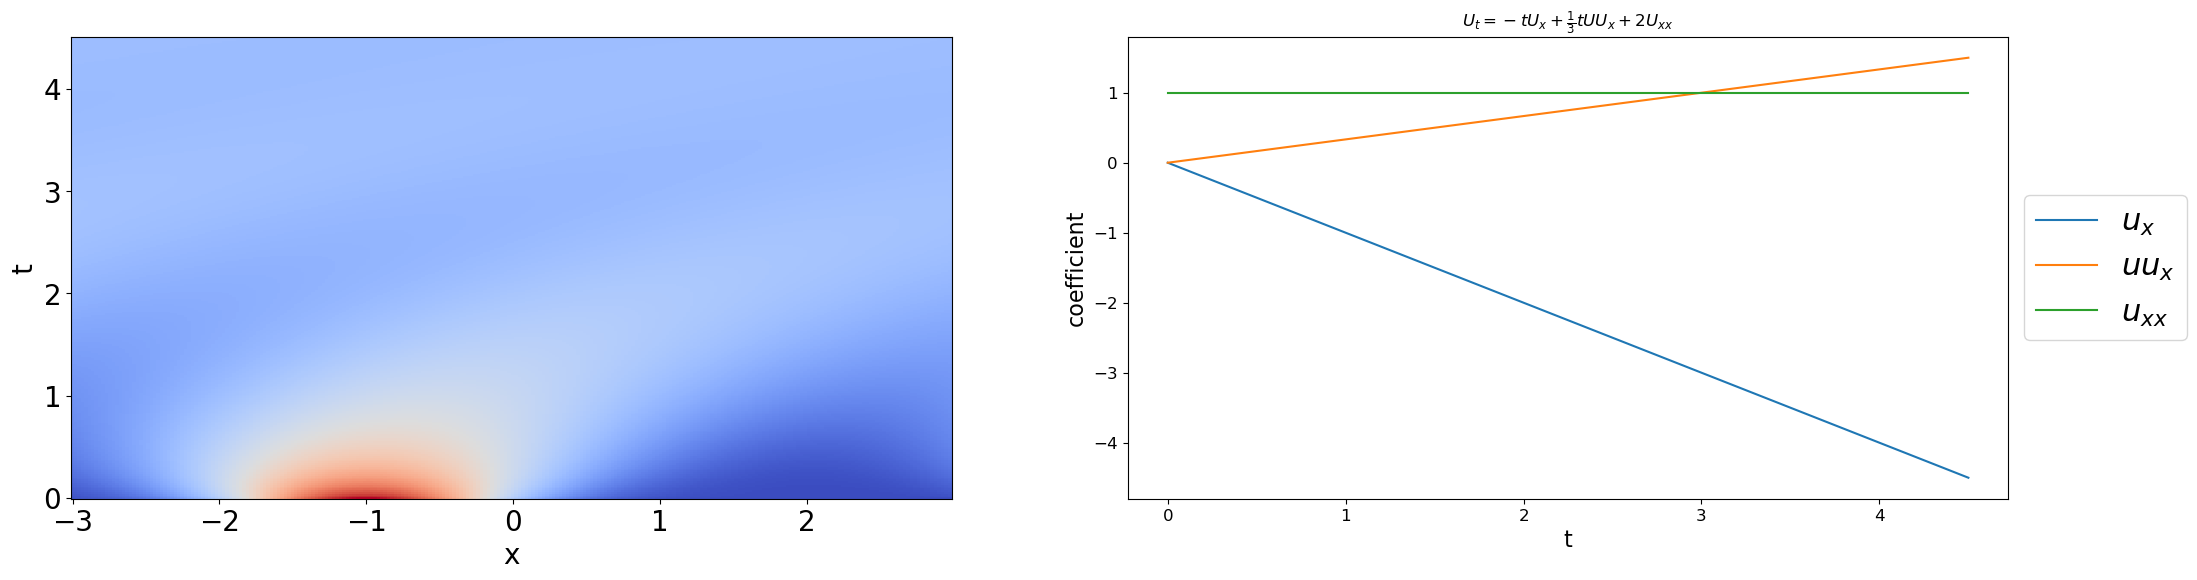

In [5]:
u_x_true = -1*t
uu_x_true = (1/3)*t
u_xx_true = 1*np.ones(m)

fig=figure(figsize=(25,6))

X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
#xlim([x[0],x[-1]])

subplot(1,2,2)
#ax.plot(t,u_true, label=r'$u$')
plot(t,u_x_true, label=r'$u_{x}$')
plot(t, uu_x_true, label=r'$uu_{x}$')
#ax.plot(x, t, u2_true, label=r'$u^2$')
plot(t, u_xx_true, label=r'$u_{xx}$') 

title( r'$U_t  =  -tU_x + \frac{1}{3}tUU_x + 2U_{xx}$')

xticks(fontsize = 12)
yticks(fontsize = 12)
xlabel('t', fontsize = 16)
ylabel('coefficient', fontsize = 16)
#zlabel('c', fontsize = 16)

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [307]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')

In [308]:
Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

MSE:  1.2630662989013106e-06


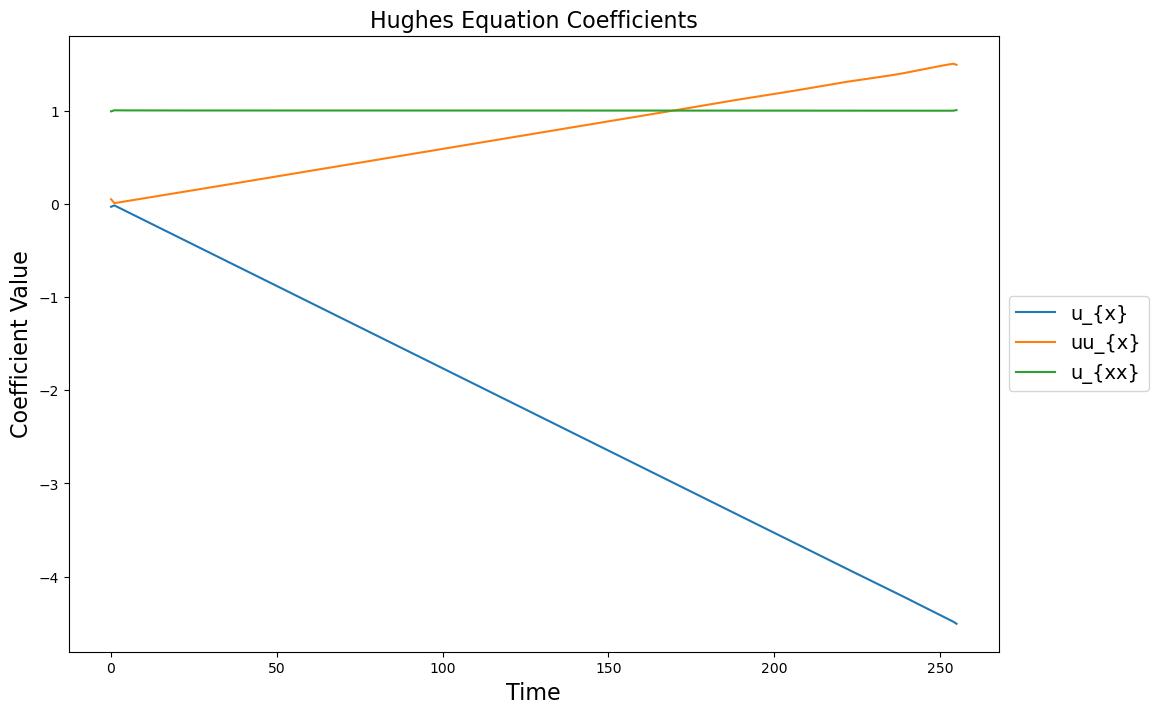

In [309]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[j])

title('Hughes Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
i_uu_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'uu_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]
xi_true = np.zeros(xi.shape)
xi_true[i_uu_x] = uu_x_true
xi_true[i_u_xx] = u_xx_true
xi_true[i_u_x] = u_x_true
mse_clean_sgtr = Norm(xi-xi_true)**2/(m*16)

print('MSE: ', mse_clean_sgtr)

In [310]:
#Create a new set of data in relation to U
un = u + 0.00001*std(u)*np.random.randn(n,m)

In [311]:
wx = 10 
wt = 10 

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=2, P=2, time_diff = 'FD',
                                       deg_x = 2, deg_t = None, 
                                       width_x = wx, width_t = wt )
n2 = n - 2*wx
m2 = m - 2*wt

In [312]:
Thetan_grouped = [real(Thetan[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utn_grouped = [real(Utn[j*n2:(j+1)*n2]) for j in range(m2)]

MSE:  0.002566702604825844


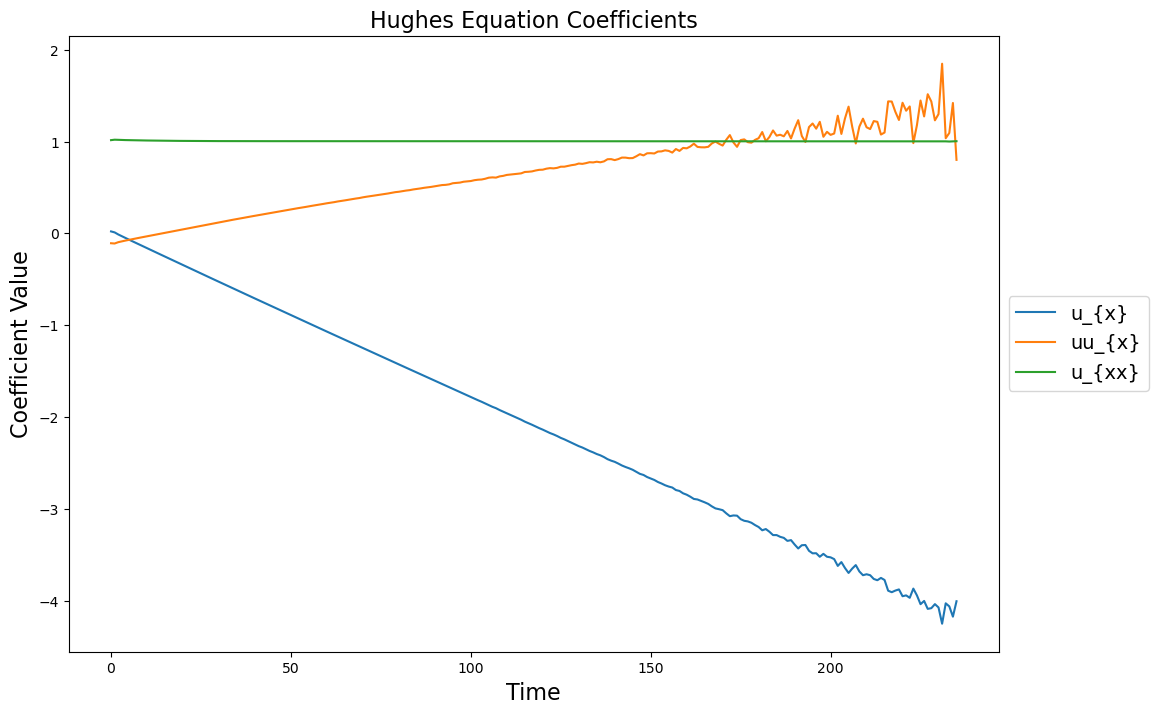

In [313]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Hughes Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_sgtr)

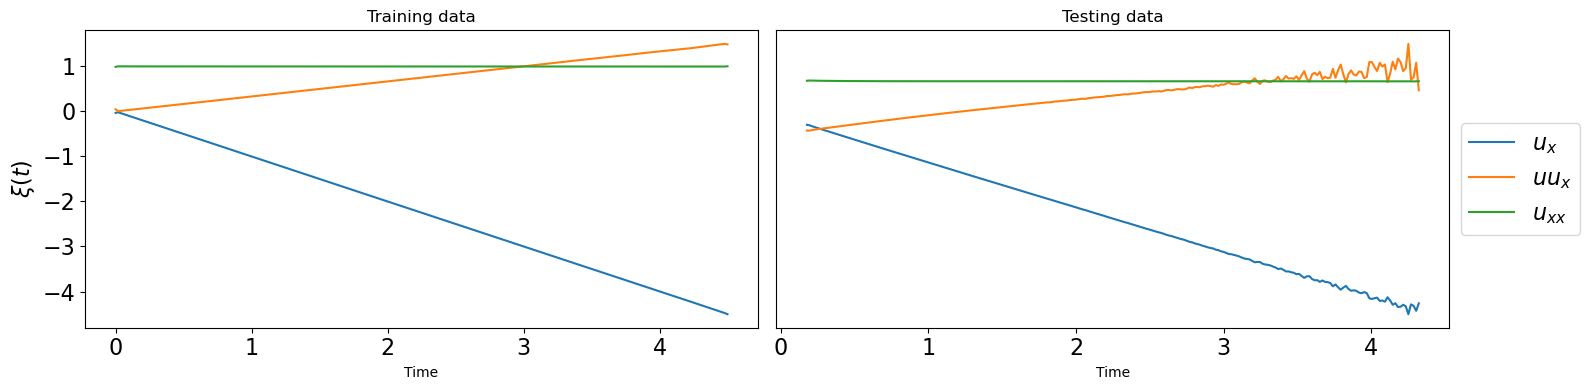

In [316]:
figure(figsize = (16,4))
label_fs = 16

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(t,xi[j,:], label = rhs_des[j])

ylabel(r'$\xi(t)$', fontsize = 16)
xlabel('Time')
xticks(fontsize = 16)
yticks(fontsize = 16)
title("Training data")

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(t[wt:-wt],xi_n[j,:], label = '$'+rhs_des[j]+'$')

xticks(fontsize = 16)
yticks([], fontsize = 16) 
title("Testing data")
xlabel('Time')


legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)

tight_layout()

In [290]:
rhs_des = build_linear_system(u, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')

In [291]:
print(rhs_des)

(array([[1.46945986e-01],
       [2.03069223e-01],
       [2.62116115e-01],
       ...,
       [3.90507093e-05],
       [4.15998172e-05],
       [4.41241467e-05]]), array([[ 1.00000000e+00,  1.83156389e-02,  3.35462628e-04, ...,
         2.55724953e-01,  4.68376589e-03,  8.57861647e-05],
       [ 1.00000000e+00,  2.01047471e-02,  4.04200857e-04, ...,
         2.74034552e-01,  5.50939537e-03,  1.10765001e-04],
       [ 1.00000000e+00,  2.20443870e-02,  4.85955000e-04, ...,
         2.92344150e-01,  6.44454760e-03,  1.42066102e-04],
       ...,
       [ 1.00000000e+00,  2.94768855e-01,  8.68886778e-02, ...,
        -1.70688212e-05, -5.03135687e-06, -1.48308730e-06],
       [ 1.00000000e+00,  2.94768426e-01,  8.68884252e-02, ...,
        -1.66509971e-05, -4.90818820e-06, -1.44677891e-06],
       [ 1.00000000e+00,  2.94767989e-01,  8.68881672e-02, ...,
        -1.62331729e-05, -4.78501972e-06, -1.41047064e-06]]), ['', 'u', 'u^2', 'u_{x}', 'uu_{x}', 'u^2u_{x}', 'u_{xx}', 'uu_{xx}', 'u^2u_{x

In [292]:
print(xi)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.96862854 2.01186225 2.00921286 ... 1.9965383  1.99636485 2.00989079]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [293]:
print(xi.shape)

(9, 256)


In [294]:
print(xi.shape)

(9, 256)


In [295]:
print(xi[:,:])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.96862854 2.01186225 2.00921286 ... 1.9965383  1.99636485 2.00989079]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [296]:
x.shape

(256,)

In [297]:
xi.shape

(9, 256)

In [298]:
print(xi[2,8])

0.0


In [299]:
print(t)

[0.         0.01764706 0.03529412 0.05294118 0.07058824 0.08823529
 0.10588235 0.12352941 0.14117647 0.15882353 0.17647059 0.19411765
 0.21176471 0.22941176 0.24705882 0.26470588 0.28235294 0.3
 0.31764706 0.33529412 0.35294118 0.37058824 0.38823529 0.40588235
 0.42352941 0.44117647 0.45882353 0.47647059 0.49411765 0.51176471
 0.52941176 0.54705882 0.56470588 0.58235294 0.6        0.61764706
 0.63529412 0.65294118 0.67058824 0.68823529 0.70588235 0.72352941
 0.74117647 0.75882353 0.77647059 0.79411765 0.81176471 0.82941176
 0.84705882 0.86470588 0.88235294 0.9        0.91764706 0.93529412
 0.95294118 0.97058824 0.98823529 1.00588235 1.02352941 1.04117647
 1.05882353 1.07647059 1.09411765 1.11176471 1.12941176 1.14705882
 1.16470588 1.18235294 1.2        1.21764706 1.23529412 1.25294118
 1.27058824 1.28823529 1.30588235 1.32352941 1.34117647 1.35882353
 1.37647059 1.39411765 1.41176471 1.42941176 1.44705882 1.46470588
 1.48235294 1.5        1.51764706 1.53529412 1.55294118 1.57058824
 1